# Using Grover's Search to Solve the Max Cut Problem

In this lab, we will see how Grover's search algorithm can be applied to practical problems. Specifically, we will use it to solve the decision variant of the Max Cut problem.

#### 1. Max Cut Introduction (adopted from IBM Quantum Challenge 2019)

The Maximum Cut problem, or Max Cut in short, is a problem involving separating the vertex set of an undirected graph into two zones in order to maximize the number of edges crossing the two zones. Here we denote any undirected graph as G, vertices as V and edges as E. The two groups when separated by a line (or a cut) will be separate zones.

Let us start with a simple example where we have (0,1,2）as our three vertices and (0,1), (1,2) as our two edges connecting these vertices.

<center>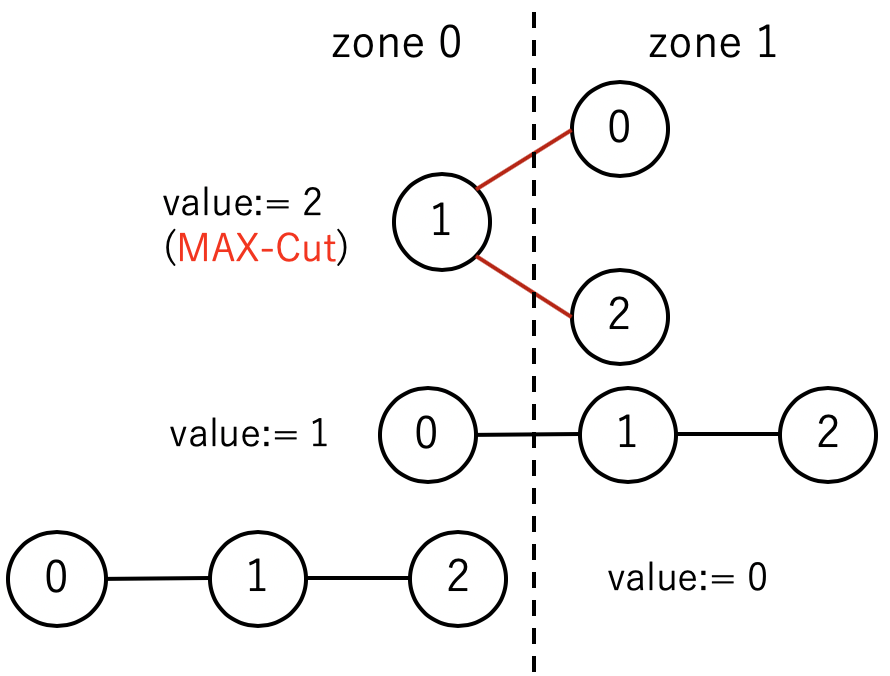</center>

Let us cut this graph to create two zones in three different ways. (The edges crossing different zones will be called 'cut-edges' from here on.) As you can see here, the first cut pattern gives us the maximum value of edges crossing different zones. And there you have it, the maximum value of cut-edges for this graph is 2.

For the sake of simplicity, we will use Grover's search to solve the decision variant of the Max Cut problem, stated as follow:

##### <center><b>Given a graph G and an integer k, determine whether there is a cut of size at least k in G.

#### 2. Quantum circuit for determining cut-edges

Consider two vertices connected by an edge, we could use 2 bits of information to represent all possible situations. Suppose for each bit, 0 means the vertex in the left seperate zone, and 1 means the vertex is in the right seperate zone. For example, suppose two bits are (0, 1), the corresponding situation is:

<center>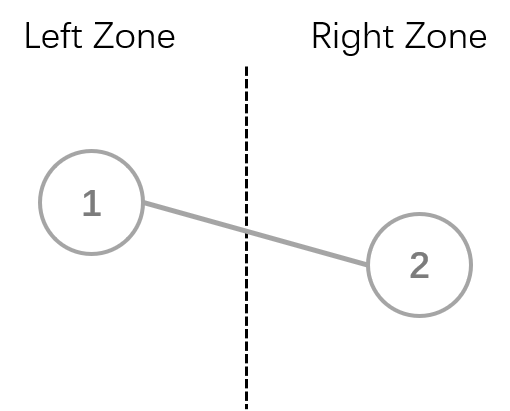</center>

We could then derive the following truth table, which is precisely the XOR operation:

|Vertex 1|Vertex 2|is a cut-edge?|
|-|-|------------|
|0|0|False|
|0|1|True|
|1|0|True|
|1|1|False|

Now we need to think about how to encode the information into qubits and gate operations. Suppose each qubit represent a vertex, and the bit value represents which zone the vertex lies in, a reversible XOR operation on these two bits could be represented as follows:

<center>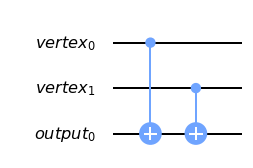</center>

Therefore, for each edge in the graph, we need to perform the reversible XOR operation on the corresponding vertices, which means we need $|E|$ qubits in the output (edge) register. For example, for the graph in Max Cut introduction section, the circuit would be:

<center>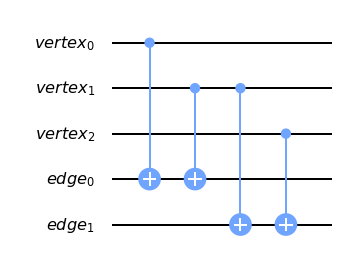</center>

#### 3. Counting the cut-edges

The next step is to count the cut-edges, namely the hamming weight of the output bitstring (number of 1s). Recall in homework 6, we discovered that the following operation performs $|x\rangle \rightarrow |x+1\rangle$:

<center>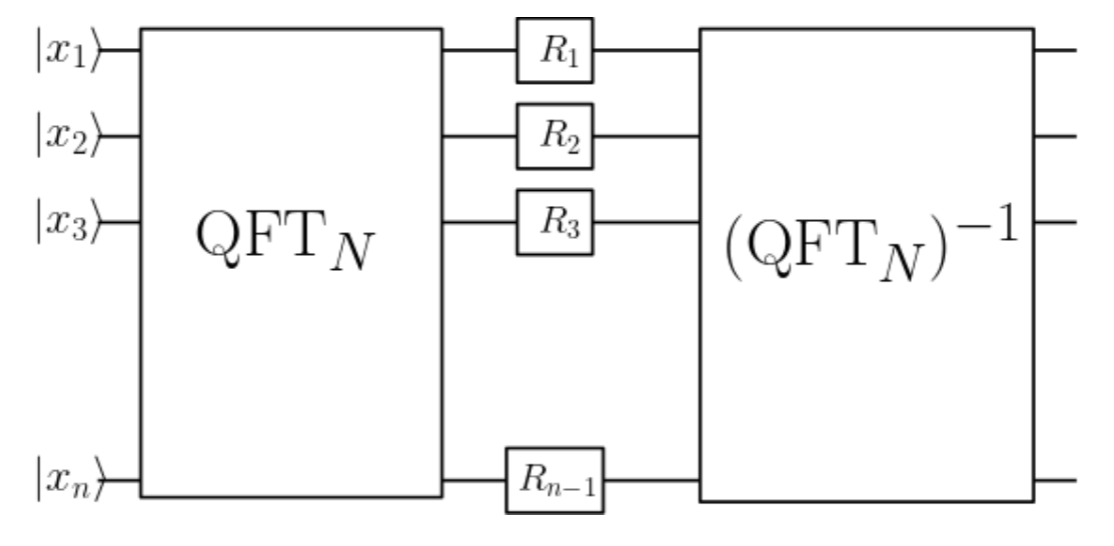</center>

where $R_k$ is defined as:

$$
R_k =
\begin{bmatrix}
1 & 0 \\
0 & e^{2\pi i/2^k}
\end{bmatrix}
$$

We could use this fact to construct an efficient bit adder.

Let's call the whole operation $U_{+1}$. If we define a controlled version of this gate, we could add one bit y to an arbitrary number x. This is because if y = 0, the gate will not be applied, which leaves $|x\rangle$ unchanged; but if y = 1, $|x\rangle$ will be transformed to $|x+1\rangle = |x+y\rangle$.

<center>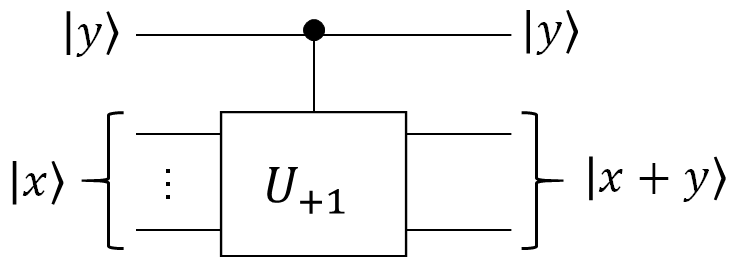</center>

Therefore, if we initialize $|x\rangle$ as $|0\rangle$ and perform a series of $CU_{+1}$, we can calculate the sum of 1s in an arbitrary bitstring $|abc...>$ (or in qiskit's order, $|...cba\rangle$).

<center>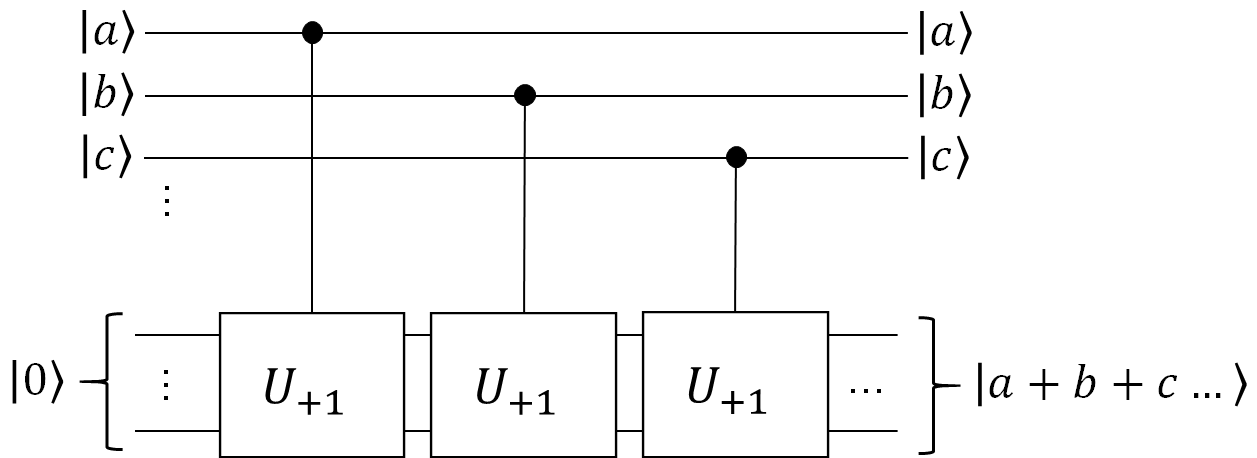</center>

In general, we need $\lfloor log_2(|E|) \rfloor + 1$ qubits in the counting register (we called it x) to account for all possible sums.

To implement $CU_{+1}$ efficiently, we can use the following fact: if the rotation gates $R_1, R_2, ...$ sandwiched by $QFT$ and $QFT^{\dagger}$ are not present, the operation is simply identity. Therefore, we only need to change each $R_k$ into the controlled version to perform $CU_{+1}$. In addition, for sequencial $CU_{+1}$, we will have adjacent $QFT^{\dagger}$ and $QFT$ canncled, which means we only need to add one $QFT$ at the start of the circuit and one $QFT^{\dagger}$ at the end of the circuit. Therefore the complete bit counter circuit would look like this:

<center>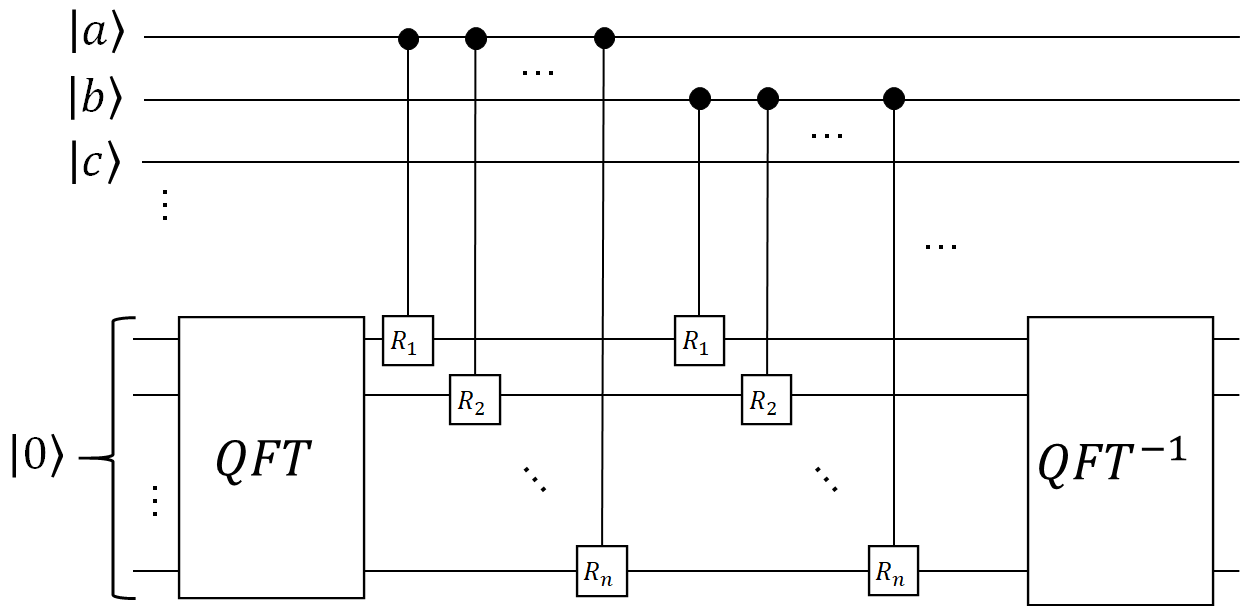</center>

#### 4. Identifying the counts

The last step is to have an operation that flips a bit if the count (call it $c$) is greater than or equal to some value $k$. This isn't easy to implement as an efficient circuit, but we have a few directions:

1. If k = 2, 4, 8, 16... we could just check the first m most significant bits (MSB), where m depends on the total number of bits. For example, suppose we have 4 qubits and $k=4$, if there's at least one 1 in the first two MSB, we know for sure $c \ge 4$.

2. A condition can be decomposed into a series of conditions connected by "and" or "or". For example, $c \ge 5$ is equivalent as $c \ge 4$ and $c \ne 4$.

3. Sometimes it's not easy to perfrom an "and" condition in quantum circuit (Note we are not talking about AND gate, but how to flip a bit based on several conditions connected by "and" or "or"). However, it would be much easier to perform the "or" condition, because a series of $MCT$ gates sandwiched by approriate $X$ gates give the "or" condition check. Recall in Grover's search's oracle, instead flipping the solution state, we could also flip all unwanted states in our oracle because it just introduces a global phase of -1 which is unobservable. This means if our statement only has "and"s, we could use De Morgan's law to change all "and"s into "or"s.

Let's now see an example. Suppose we want to check if $c \ge 5$. We saw in $2.$ that it's equivalent as $c \ge 4$ and $c \ne 4$. The negation of this statement is $c \lt 4$ or $c = 4$, which implies the following circuit:

<center>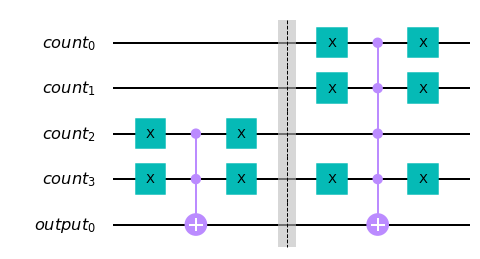</center>

The first $CCX$ gate sandwiched by 4 $X$ gates flips the output qubit only if $c < 4$ because Base10(00xx) < 4. The next $MCT$ gate sandwiched by 6 $X$ gates only flips the output qubit if $c = 4$.

#### 5. Putting it together

As for now, we have all pieces to construct the oracle implementation of the decision variant of Max Cut problem. Following the steps we have, we have the following circuit for our oracle:

<center>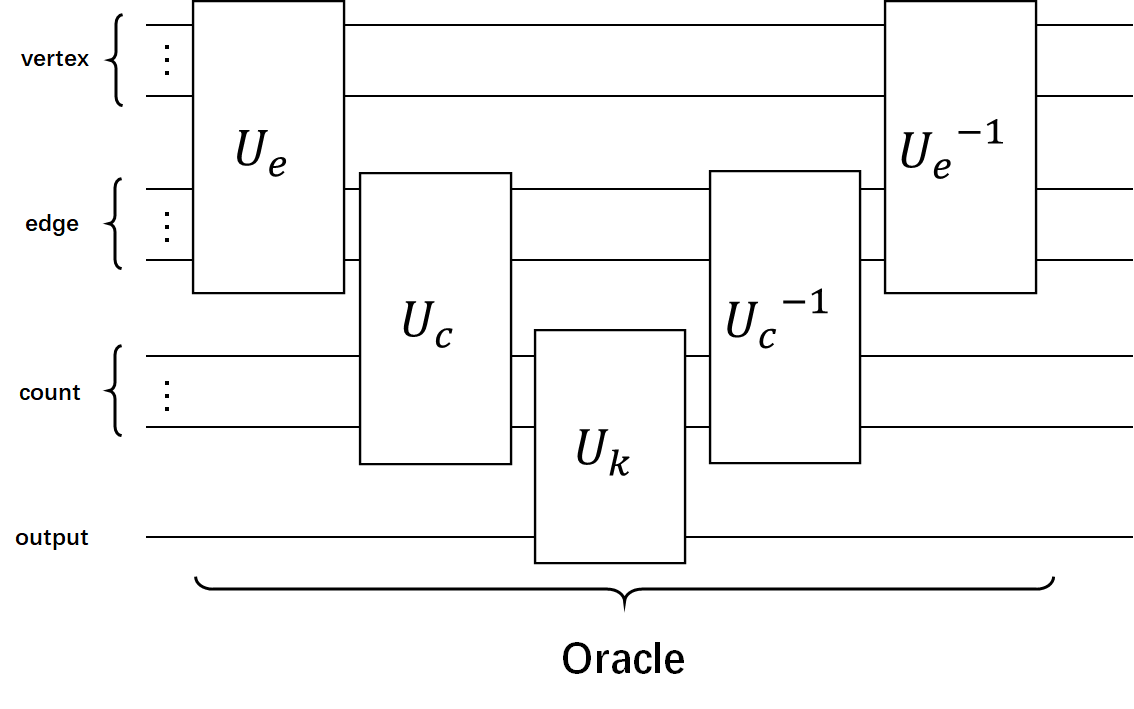</center>

where $U_e$ determines the if an edge is cutted by the seperating line, $U_c$ counts the number of edges being cutted, and $U_k$ checks if the count is greater than or equal to k. The whole circuit will flip the output qubit when there is a cut of size at least k in the underlying graph. Notice the step where we apply $U_e^{-1}$ and $U_c^{-1}$ in order to uncompute the edge register and count register. This step is crucial because we want to unentangle those registers.

In order to perform Grover's search, the vertex register needs to be initialized to a uniform superposition of all states, which represents all possible ways to seperate the edges in the graph. The output qubit is initialized to $|-\rangle$ state in order to have our oracle flips the phase instead of the bit value. We also need the diffuser operation to flip over mean. For 1 iteration, we have the circuit shown below:

<center>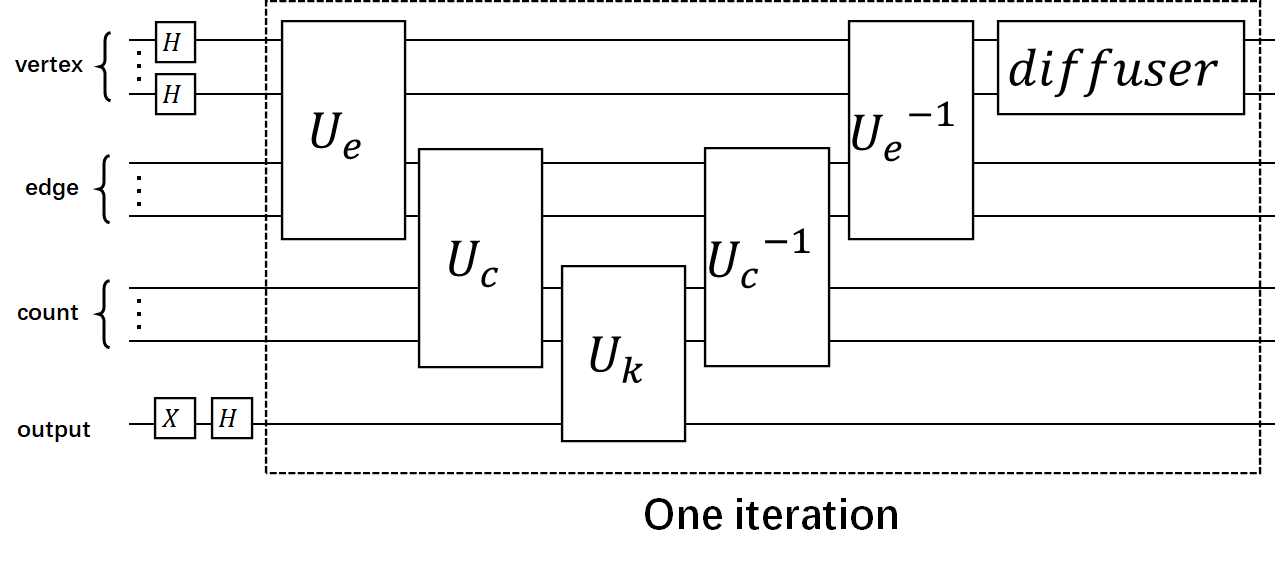</center>

If more iterations are needed, we could just repeat the circuit block enclosed in the dotted lines.

#### 6. Implementation (Lab part)

<center><b>Consider the graph below, use Grover's search to determine if there is a cut of size at least 6. If the answer is yes, list all the possible cuts (represented as bitstrings).

<center>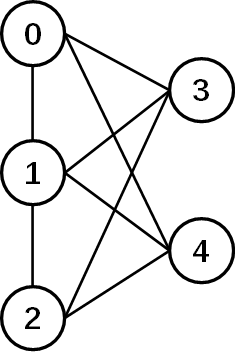</center>

You could use the code template below. However, feel free to develop your own code structure. In addition, as long as you could determine the cuts, you could use any number of Grover search iterations.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, execute, Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import numpy as np

In [ ]:
# Section 2

def U_e(num_vertex_bits, num_edge_bits):

    qrv = QuantumRegister(num_vertex_bits, name='vertex')
    qre = QuantumRegister(num_edge_bits, name='edge')
    qc = QuantumCircuit(qrv, qre)
    
    ####### TODO: Implement a circuit that determines cut-edges ########
    
    
    
    ####################################################################
    
    return qc

In [ ]:
# Section 3

def U_c(num_edge_bits, num_count_bits):

    qre = QuantumRegister(num_edge_bits, name='edge')
    qrc = QuantumRegister(num_count_bits, name='count')
    qc = QuantumCircuit(qre, qrc)
    qc.append(QFT(num_count_bits, do_swaps=False), qrc[::-1])
    
    ############## TODO: Implement controlled-rotations ################
    
    
    
    ####################################################################
    
    qc.append(QFT(num_count_bits, do_swaps=False, inverse=True), qrc[::-1])
    return qc

In [ ]:
# Section 4

def U_k(num_count_bits):

    qrc = QuantumRegister(num_count_bits, name='count')
    qro = QuantumRegister(1, name='output')
    qc = QuantumCircuit(qrc, qro)
    
    ##### TODO: Implement a circuit that identifies the count value ####

    
    
    ####################################################################
    
    return qc

In [ ]:
# diffuser circuit

def diffuser(num_edge_bits):

    qrc = QuantumRegister(num_edge_bits, name='edge')
    qc = QuantumCircuit(qrc)
    
    ############### TODO: Implement the diffuser circuit ###############
    
    
    
    ####################################################################
    
    return qc

In [ ]:
# Grover's search circuit

def max_cut_grover(num_vertex_bits, num_edge_bits, num_count_bits):
    
    qrv = QuantumRegister(num_vertex_bits, name='vertex')
    qre = QuantumRegister(num_edge_bits, name='edge')
    qrc = QuantumRegister(num_count_bits, name='count')
    qro = QuantumRegister(1, name='output')
    cr = ClassicalRegister(num_vertex_bits, name='m')
    qc = QuantumCircuit(qrv, qre, qrc, qro, cr)

    ########### TODO: Implement the grover's search circuit ############
    # Tips: 
    #    1. circ.inverse() will return the inverse of your quantum circuit
    #    2. Use circ1.append(circ2, reg1[:]+reg2[:]) to connect circuits that use more than one registers
    
    
    
    ####################################################################
    
    qc.measure(qrv, cr)
    
    return qc

In [ ]:
# TODO: change the variables to the number of qubits you need
num_vertex_bits = None
num_edge_bits = None
num_count_bits = None

# plot the histogram of resulting circuit
result_circ = max_cut_grover(num_vertex_bits, num_edge_bits, num_count_bits)
qasm_sim = Aer.get_backend('qasm_simulator')
results = execute(result_circ, backend=qasm_sim).result()
counts = results.get_counts()
plot_histogram(counts)